### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helpfunction as helper
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
x_sce_magic = 1.03
seed = 7
test_size = 0.4
pid_upper_clip = 300
pot_target = 1e20

<IPython.core.display.Javascript object>

In [5]:
max_trk_score = 0.85
min_cluster_frac = 0.5

<IPython.core.display.Javascript object>

### Load Samples

In [6]:
input_dir = "./input/7Oct/run3/"
output_dir = "./output/run3/"

<IPython.core.display.Javascript object>

In [7]:
sample_info, fields, signal_mask = helper.load_sample_info(input_dir, "sample_info.txt")
pot_scale = pot_target / sample_info["On"]["POT"]

Passing rate after Slice ID:
On 	23.27%
Off 	14.61%
MC 	43.93%
MC sample: nueccinc passing Slice ID 	84.22%
NUE 	79.69%
NUE sample: nueccinc passing Slice ID 	84.78%
DRT 	22.50%
Completed, time passed: 61.9s.


<IPython.core.display.Javascript object>

### Explore Tree

In [8]:
pot_nue = sample_info["NUE"]["POT"]
print("POT nue from sample:", pot_nue)
pot_nue_scaling = sample_info["On"]["POT"] / sample_info["NUE"]["scaling"]
print("POT nue from scaling:", pot_nue_scaling)

POT nue from sample: 9.282719e+22
POT nue from scaling: 9.239795918367347e+22


<IPython.core.display.Javascript object>

In [9]:
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [10]:
mc_fields

['true_pt',
 'true_pt_visible',
 'true_p',
 'true_p_visible',
 'true_e_visible',
 'true_nu_vtx_t',
 'true_nu_vtx_x',
 'true_nu_vtx_y',
 'true_nu_vtx_z',
 'true_nu_vtx_sce_x',
 'true_nu_vtx_sce_y',
 'true_nu_vtx_sce_z',
 'mc_pdg',
 'mc_E',
 'mc_vx',
 'mc_vy',
 'mc_vz',
 'mc_endx',
 'mc_endy',
 'mc_endz',
 'mc_px',
 'mc_py',
 'mc_pz',
 'mc_completeness',
 'mc_purity']

<IPython.core.display.Javascript object>

In [11]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v']

<IPython.core.display.Javascript object>

In [12]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_dist_v',
 'shr_nclus_v',
 'shr_clushitfrac_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v',
 'shr_spacepoint_start_U_v',
 'shr_spacepoint_start_V_v',
 'shr_hits_start_U_wire_v',
 'shr_hits_start_U_x_v',
 'shr_hits_start_V_wire_v',
 'shr_hits_start_V_x_v',
 'shr_hits_start_Y_wire_v',
 'shr_hits_start_Y_x_v']

<IPython.core.display.Javascript object>

In [13]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [14]:
other_fields

{'CosmicIP',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_boundary',
 'elec_c',
 'elec_dist',
 'elec_e',
 'elec_edep',
 'elec_etot',
 'elec_p',
 'elec_parent',
 'elec_vx',
 'elec_vy',
 'elec_vz',
 'endmuonmichel',
 'endmuonprocess',
 'evgamnhits',
 'evlepnhits',
 'evneunhits',
 'evnhits',
 'evnunhits',
 'evothnhits',
 'evpi0nhits',
 'evpi1nhits',
 'evpronhits',
 'evt',
 'extra_energy_y',
 'frac_slnoise_pl1',
 'gamma1_edep',
 'gamma1_etot',
 'gamma2_edep',
 'gamma2_etot',
 'gamma_dist',
 'gamma_edep',
 'gamma_etot',
 '

<IPython.core.display.Javascript object>

In [15]:
# search through fields:
[f for f in fields if "con" in f]

['n_tracks_contained', 'n_showers_contained', 'contained_fraction']

<IPython.core.display.Javascript object>

### Add fields

In [16]:
%%time
# For all samples
for k, v in sample_info.items():
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    # Add maxangle
    # Todo
    # a.distinct(b, nested=True)
    
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score & shr_tkfit_dedx_nhits_y_v>0'    
    data = v["daughters"][
                [
                    "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                    "trk_score_v",'shr_tkfit_dedx_nhits_y_v',
                    "shr_energy_y_v",
                ]
            ]
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby("event").transform(max) == data[electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add dedx for plane with most hits:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                    "shr_tkfit_dedx_v_v",
                    "shr_tkfit_dedx_y_v",
                    'shr_tkfit_nhits_v',
                    "shr_tkfit_dedx_nhits_u_v",
                    "shr_tkfit_dedx_nhits_v_v",
                    "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/(shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add weigthed pid chi mu/pr:
    pid_chi_cols = ["trk_pid_chipr_v",
    "trk_pid_chimu_v",
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v"]
    v["daughters"][pid_chi_cols]=v["daughters"][pid_chi_cols].clip(upper=pid_upper_clip)
    str_pidmu_weighted_mean='(trk_pid_chimu_v*pfnplanehits_Y+trk_pid_chimu_v_v*pfnplanehits_V+trk_pid_chimu_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chimu_wm_v']= v["daughters"].eval(str_pidmu_weighted_mean)
    str_pidpr_weighted_mean='(trk_pid_chipr_v*pfnplanehits_Y+trk_pid_chipr_v_v*pfnplanehits_V+trk_pid_chipr_u_v*pfnplanehits_U)/pfnhits'
    v["daughters"]['trk_pid_chipr_wm_v']= v["daughters"].eval(str_pidpr_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen']= v["daughters"].eval('pfnhits/trk_len_v')
    
    # Drop columns I do not need anymore:
    drop_cols = [
    "pfnplanehits_U",
    "pfnplanehits_V",
    "pfnplanehits_Y",
    'pfnhits',
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_nhits_v",
    "shr_tkfit_dedx_nhits_u_v",
    "shr_tkfit_dedx_nhits_v_v",    
    "trk_pid_chipr_v_v",
    "trk_pid_chimu_v_v",
    "trk_pid_chipr_u_v",
    "trk_pid_chimu_u_v",
]
for c in drop_cols:
    if c in v["daughters"].columns:
        v["daughters"].drop(c, inplace=True, axis=1)
    else:
        print(c, " was not in dataframe!")

CPU times: user 2.89 s, sys: 88 ms, total: 2.98 s
Wall time: 1.93 s


<IPython.core.display.Javascript object>

In [17]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k in helper.mc_samples:
        
        # Correct the LEE weight using the splineweight
        v['daughters']["leeweight"]*=v['daughters']["weightSpline"]
        
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Add the distance between the true neutrino vertex and the reconstructed shower start point
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "shr_tkfit_start_x_v",
                    "shr_tkfit_start_y_v",
                    "shr_tkfit_start_z_v",
                ]
            ]
            .values.T
        )
        v["daughters"]["true_shower_distance"] = np.linalg.norm(data[0:3] - data[3:6], axis=0)
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0
        
        # Drop some stuff you do not need anymore
        drop_cols = ['backtracked_overlay_purity',
                     "true_nu_vtx_sce_y",
                     "true_nu_vtx_sce_z",
                     "reco_nu_vtx_y",
                     "reco_nu_vtx_z"]
        for c in drop_cols:
            if c in v["daughters"].columns:
                v["daughters"].drop(c, inplace=True, axis=1)
            else:
                print(c, " was not in dataframe!")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


CPU times: user 2.25 s, sys: 252 ms, total: 2.5 s
Wall time: 1.38 s


<IPython.core.display.Javascript object>

In [18]:
%%time
# For MC samples, fields needed as training labels:
for k, v in sample_info.items():
    if k in helper.mc_samples:
        # Add training labels and weights
        e_cand = v["daughters"]['e_candidate']
        e_good = v["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.75 & backtracked_completeness>0.5')
        e_cand_bad = v["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11')
        other_bad = v["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13) | backtracked_pdg==22 | backtracked_pdg==0')
        
        v["daughters"]['train_weight'] = v["daughters"][["weightSpline","leeweight"]].max(axis=1) # weight low energy electrons a bit higher
        v["daughters"].loc[e_good, "train_weight"] *= 5 # can be tuned
        
        v["daughters"]['train_label'] = True
        v["daughters"].loc[e_cand_bad, "train_label"] = False
        v["daughters"].loc[other_bad, "train_label"] = False

CPU times: user 944 ms, sys: 84.1 ms, total: 1.03 s
Wall time: 515 ms


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [19]:
query_preselect = (
    "e_candidate & reco_fid_vol & slclustfrac>@min_cluster_frac & ~crtveto"
)

<IPython.core.display.Javascript object>

In [20]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby("event").transform(max)
    
    pass_rate = sum(v["daughters"].eval("e_candidate & preselect"))/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["NUE"]['daughters'].eval('(e_candidate & preselect)*weightSpline*nueccinc'))/sum(sample_info["NUE"]["mc"]['weightSpline']*signal_mask)
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["NUE"]['daughters'].eval('(e_candidate & preselect)*nueccinc'))*sample_info["NUE"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["NUE"]['daughters'].eval('(e_candidate & preselect)*leeweight*nueccinc'))*sample_info["NUE"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["MC"]["daughters"].eval("preselect*weightSpline"))
    * sample_info["MC"]["scaling"]
)
purity_denom += (
    sum(sample_info["DRT"]["daughters"].eval("preselect*weightSpline"))
    * sample_info["DRT"]["scaling"]
)
purity_denom += (
    sum(sample_info["Off"]["daughters"].eval("preselect")) * sample_info["Off"]["scaling"]
)

purity_mc = (
    sum(sample_info["NUE"]["daughters"].eval("preselect*weightSpline*nueccinc"))
    * sample_info["NUE"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["NUE"]["daughters"].eval("preselect*weightSpline*nueccinc"))
    * sample_info["NUE"]["scaling"]
    / sum(sample_info["On"]["daughters"].eval("preselect"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["On"]["daughters"].eval("preselect")) / purity_denom,
    )
)

On 	3.39%
Off 	1.74%
MC 	8.96%
NUE 	52.16%
DRT 	1.36%
Nue signal passing the preselection 	63.90%
Nue Intrinsic signal passing: 84.291 per 1e+20 POT
Nue LEE signal passing: 8.720 per 1e+20 POT


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Purity MC: 0.7%
Data/MC-ratio: 1.01

CPU times: user 1.23 s, sys: 12.1 ms, total: 1.24 s
Wall time: 621 ms


<IPython.core.display.Javascript object>

### Machine Learning: Daughter training!

In [21]:
col_train_electron = [
    "topological_score",
    "n_showers",
    "n_tracks",
    "trk_score_v",
    "trk_len_v",
    "trk_pid_chipr_v",
    "trk_pid_chimu_v",
    "shr_dist_v",
    "shr_energy_y_v",
    "shr_openangle_v",
    "shr_tkfit_theta_v",
    "shr_tkfit_phi_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_dedx_nhits_y_v",
    ##"train_weight",
    ##"train_label",
]
col_train_other = [
    "topological_score",
    "n_pfps",
    "n_showers",
    "n_tracks",
    "trk_score_v",
    "trk_distance_v",
    "trk_theta_v",
    "trk_phi_v",
    "trk_len_v",
    "trk_pid_chimu_wm_v",
    "trk_pid_chipr_wm_v",
    "shr_energy_y_v",
    "shr_openangle_v",
    "shr_tkfit_dedx_wm_v",
    "hits_per_tklen"
    ##"train_weight",
    ##"train_label",
]

col_train_event = [
    "topological_score",
    "n_showers",
    "n_tracks",
    "hits_ratio",
    "contained_fraction",
    "score",
    "score_other_max",
    "score_other_min",
    "score_other_mean"
    # "nu_flashmatch_score",
    # maxangle
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

#### Electron training

In [22]:
train_q = "preselect & e_candidate"
X = sample_info["NUE"]["daughters"].query(train_q)[col_train_electron]
Y = sample_info["NUE"]["daughters"].query(train_q)[["train_label", "train_weight"]]
Xnue_train, Xnue_test, ynue_train, ynue_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
X = sample_info["MC"]["daughters"].query(train_q)[col_train_electron]
Y = sample_info["MC"]["daughters"].query(train_q)[["train_label", "train_weight"]]
Xmc_train, Xmc_test, ymc_train, ymc_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
# Merge our two samples
X_train = pd.concat([Xmc_train, Xnue_train]).reset_index(drop=True)
y_train = pd.concat([ymc_train, ynue_train]).reset_index(drop=True)
X_test = pd.concat([Xmc_test, Xnue_test]).reset_index(drop=True)
y_test = pd.concat([ymc_test, ynue_test]).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [23]:
# fit model no training data
model_e = XGBClassifier(max_depth=6)
model_e.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [24]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.92      0.76      0.83     35893
non_electron       0.75      0.92      0.83     28337

    accuracy                           0.83     64230
   macro avg       0.84      0.84      0.83     64230
weighted avg       0.85      0.83      0.83     64230

Test accuracy: 82.84%
Train accuracy: 83.58%

1. feature shr_energy_y_v (0.508103)
2. feature shr_dist_v (0.074251)
3. feature trk_len_v (0.063700)
4. feature trk_score_v (0.059643)
5. feature n_tracks (0.051354)
6. feature n_showers (0.048789)
7. feature trk_pid_chipr_v (0.038220)
8. feature shr_tkfit_dedx_wm_v (0.036392)
9. feature trk_pid_chimu_v (0.027992)
10. feature shr_tkfit_dedx_y_v (0.023614)
11. feature topological_score (0.021601)
12. feature shr_tkfit_dedx_nhits_y_v (0.016635)
13. feature shr_tkfit_theta_v (0.013327)
14. feature shr_openangle_v (0.008435)
15. feature shr_tkfit_phi_v (0.007943)


<IPython.core.display.Javascript object>

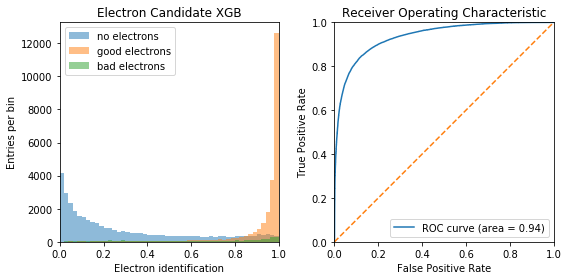

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_e.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="no electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] > 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="good electrons",
    density=False,
)
ax[0].hist(
    y_pred[(y_test["train_label"] == 1) & (y_test["train_weight"] < 2)],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="bad electrons",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Electron Candidate XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "e_bdt_test.pdf")

#### Other daughters training

In [26]:
train_q = "preselect & ~e_candidate"
X = sample_info["NUE"]["daughters"].query(train_q)[col_train_other]
Y = sample_info["NUE"]["daughters"].query(train_q)[["train_label", "train_weight"]]
Xnue_train, Xnue_test, ynue_train, ynue_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
X = sample_info["MC"]["daughters"].query(train_q)[col_train_other]
Y = sample_info["MC"]["daughters"].query(train_q)[["train_label", "train_weight"]]
Xmc_train, Xmc_test, ymc_train, ymc_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
# Merge our two samples
X_train = pd.concat([Xmc_train, Xnue_train]).reset_index(drop=True)
y_train = pd.concat([ymc_train, ynue_train]).reset_index(drop=True)
X_test = pd.concat([Xmc_test, Xnue_test]).reset_index(drop=True)
y_test = pd.concat([ymc_test, ynue_test]).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [27]:
# fit model no training data
model_d = XGBClassifier(max_depth=6)
model_d.fit(X_train, y_train["train_label"], sample_weight=y_train["train_weight"])

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [28]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.80      0.74      0.77     83729
muon, overlay, photon       0.77      0.81      0.79     86606

             accuracy                           0.78    170335
            macro avg       0.78      0.78      0.78    170335
         weighted avg       0.78      0.78      0.78    170335

Test accuracy: 78.00%
Train accuracy: 78.57%

1. feature trk_distance_v (0.218523)
2. feature trk_pid_chipr_wm_v (0.177101)
3. feature trk_len_v (0.146739)
4. feature trk_score_v (0.106387)
5. feature trk_theta_v (0.058102)
6. feature trk_pid_chimu_wm_v (0.048192)
7. feature topological_score (0.047719)
8. feature n_tracks (0.039976)
9. feature n_showers (0.036189)
10. feature shr_energy_y_v (0.032805)
11. feature shr_tkfit_dedx_wm_v (0.032055)
12. feature hits_per_tklen (0.024563)
13. feature n_pfps (0.021769)
14. feature trk_phi_v (0.005342)
15. feature shr_openangle_v (0.004538)


<IPython.core.display.Javascript object>

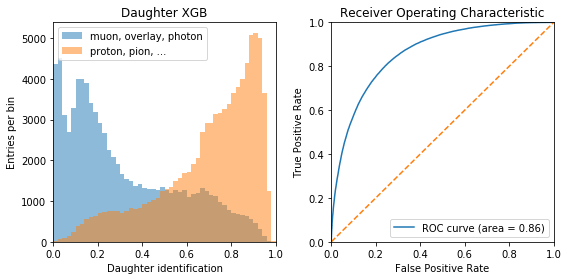

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_d.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="muon, overlay, photon",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="proton, pion, ...",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Daughter identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Daughter XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "daughter_bdt_test.pdf")

#### Apply models on the samples!

In [30]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


<IPython.core.display.Javascript object>

#### Train on the events

In [31]:
%%time
# First we need to add some columns:
for k, v in sample_info.items():    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby("event")
        .min()
        .values
    )

CPU times: user 584 ms, sys: 32 ms, total: 616 ms
Wall time: 616 ms


<IPython.core.display.Javascript object>

In [32]:
train_q = "preselect & e_candidate"
X = sample_info["NUE"]["daughters"].query(train_q)[col_train_event]
Y = sample_info["NUE"]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
Xnue_train, Xnue_test, ynue_train, ynue_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
X = sample_info["MC"]["daughters"].query(train_q)[col_train_event]
Y = sample_info["MC"]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
Xmc_train, Xmc_test, ymc_train, ymc_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)
# Merge our two samples
X_train = pd.concat([Xmc_train, Xnue_train]).reset_index(drop=True)
y_train = pd.concat([ymc_train, ynue_train]).reset_index(drop=True)
X_test = pd.concat([Xmc_test, Xnue_test]).reset_index(drop=True)
y_test = pd.concat([ymc_test, ynue_test]).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [33]:
# fit model no training data
model_event = XGBClassifier(max_depth=4)
model_event.fit(X_train, y_train["nueccinc"], sample_weight=y_train["train_weight"])

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [34]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nueccinc"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nueccinc"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nueccinc"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.89      0.74      0.81     32683
background events       0.77      0.91      0.83     31547

         accuracy                           0.82     64230
        macro avg       0.83      0.82      0.82     64230
     weighted avg       0.83      0.82      0.82     64230

Test accuracy: 82.31%
Train accuracy: 82.82%

1. feature score (0.682740)
2. feature contained_fraction (0.068210)
3. feature hits_ratio (0.049849)
4. feature n_showers (0.045276)
5. feature score_other_mean (0.040845)
6. feature n_tracks (0.035755)
7. feature score_other_max (0.034378)
8. feature score_other_min (0.026172)
9. feature topological_score (0.016775)


<IPython.core.display.Javascript object>

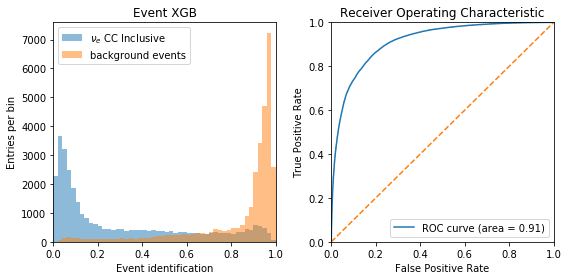

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

y_pred = model_event.predict_proba(X_test).T[1]
fpr, tpr, _ = roc_curve(y_test["nueccinc"], y_pred)
roc_auc = auc(fpr, tpr)

ax[0].hist(
    y_pred[y_test["nueccinc"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nueccinc"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("Event XGB")

ax[1].plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")

fig.tight_layout()
fig.savefig(output_dir + "event_bdt_test.pdf")

In [36]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


<IPython.core.display.Javascript object>

In [37]:
query_select = "e_candidate & preselect & score_event>0.96"
# Passing rate selection
for k, v in sample_info.items():
    v["daughters"]["select"] = v["daughters"].eval(query_select)
    pass_rate = sum(v["daughters"].eval("e_candidate & select")) / v["numentries"]
    print(k, "\t{:.4f}%".format(pass_rate * 100))

# Passing rate signal, weights applied!
pass_rate = sum(
    sample_info["NUE"]["daughters"].eval("select*weightSpline*nueccinc")
) / sum(sample_info["NUE"]["mc"]["weightSpline"] * signal_mask)
print("Nue signal passing the selection \t{:.2f}%".format(pass_rate * 100))
nue_pass = (
    sum(sample_info["NUE"]["daughters"].eval("select*weightSpline*nueccinc"))
    * sample_info["NUE"]["scaling"]
    * pot_scale
)
print(
    "Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(
        nue_pass, pot_target
    )
)
lee_pass = (
    sum(sample_info["NUE"]["daughters"].eval("select*leeweight*nueccinc"))
    * sample_info["NUE"]["scaling"]
    * pot_scale
)
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass, pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["MC"]["daughters"].eval("select*weightSpline"))
    * sample_info["MC"]["scaling"]
)
purity_denom += (
    sum(sample_info["DRT"]["daughters"].eval("select*weightSpline"))
    * sample_info["DRT"]["scaling"]
)
purity_denom += (
    sum(sample_info["Off"]["daughters"].eval("select")) * sample_info["Off"]["scaling"]
)

purity_mc = (
    sum(sample_info["NUE"]["daughters"].eval("select*weightSpline*nueccinc"))
    * sample_info["NUE"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["NUE"]["daughters"].eval("select*weightSpline*nueccinc"))
    * sample_info["NUE"]["scaling"]
    / sum(sample_info["On"]["daughters"].eval("select"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["On"]["daughters"].eval("select")) / purity_denom,
    )
)

On 	0.0230%
Off 	0.0013%
MC 	0.0798%
NUE 	15.7818%
DRT 	0.0020%
Nue signal passing the selection 	19.85%
Nue Intrinsic signal passing: 26.349 per 1e+20 POT
Nue LEE signal passing: 1.332 per 1e+20 POT
Purity MC: 38.5%
Data/MC-ratio: 1.29



<IPython.core.display.Javascript object>

In [38]:
np.savetxt(
    output_dir + "events_run3.txt",
    sample_info["On"]["daughters"].query("select")[["run", "sub", "evt"]],
    fmt="%u",
)
sample_info["On"]["daughters"].query("select")

,,run,sub,evt,topological_score,n_pfps,n_showers,n_tracks,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,reco_nu_vtx_x,reco_nu_vtx_y,reco_nu_vtx_z,crtveto,slclustfrac,hits_ratio,nu_flashmatch_score,contained_fraction,trk_score_v,trk_distance_v,trk_theta_v,trk_phi_v,trk_len_v,trk_pid_chipr_v,trk_pid_chimu_v,trk_pid_chipr_v_v,trk_pid_chimu_v_v,trk_pid_chipr_u_v,trk_pid_chimu_u_v,shr_dist_v,shr_energy_y_v,shr_openangle_v,shr_tkfit_start_x_v,shr_tkfit_start_y_v,shr_tkfit_start_z_v,shr_tkfit_theta_v,shr_tkfit_phi_v,shr_tkfit_dedx_u_v,shr_tkfit_dedx_v_v,shr_tkfit_dedx_y_v,shr_tkfit_nhits_v,shr_tkfit_dedx_nhits_u_v,shr_tkfit_dedx_nhits_v_v,shr_tkfit_dedx_nhits_y_v,pfnplanehits_U,pfnplanehits_V,pfnplanehits_Y,pfnhits,reco_fid_vol,e_candidate,shr_tkfit_dedx_wm_v,trk_pid_chimu_wm_v,trk_pid_chipr_wm_v,hits_per_tklen,preselect,score,score_other_max,score_other_mean,score_other_min,score_event,select
event,daughter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1359,0,14343,202,10145,0.419378,2,1,1,25.395136,97.323013,583.057068,25.580269,96.982986,583.056335,0,0.884161,0.971925,21.170389,1.000000,0.009000,1.457214,0.387370,0.802079,37.897610,134.053650,25.382124,173.902130,24.656149,300.000000,39.114437,1.401145,481.890564,1.439058e+23,26.633358,99.138939,585.849976,0.735017,1.107088,9.348559,12.555197,13.091320,175,3,12,10,168,286,273,727,True,True,12.384850,28.269882,188.077931,19.183268,True,0.981009,0.873256,0.873256,0.873256,0.973484,True
3775,0,17440,178,8940,0.989781,3,2,1,55.365685,-84.695442,352.824158,56.216091,-85.261398,352.846191,0,0.636424,0.980229,6.531017,1.000000,0.001713,2.211314,0.611458,2.222867,122.525688,162.615219,21.528435,260.217163,27.228617,300.000000,37.097431,2.743068,425.784698,7.284401e+00,55.980244,-85.040054,353.049988,0.585266,2.340334,0.000000,1.827204,3.605645,150,0,10,6,213,285,348,846,True,True,2.494120,27.368563,230.085092,6.904675,True,0.962800,0.891670,0.860013,0.828355,0.961677,True
10350,0,14772,92,4642,0.562693,3,1,2,124.428589,36.029896,156.916733,126.257462,33.636250,157.420395,0,0.682099,0.656109,7.466246,1.000000,0.288617,0.975417,1.437682,1.435982,60.197311,141.192719,19.132467,120.719780,10.054595,150.129425,2.605515,0.978611,186.534897,8.995379e-36,126.496620,35.295010,155.649994,1.168931,1.391641,2.001857,1.629661,4.812189,162,9,13,2,39,177,74,290,True,True,2.034445,11.369245,129.898999,4.817491,True,0.929026,0.912664,0.805306,0.697948,0.972822,True
11437,0,14136,12,643,0.848213,6,5,1,57.590057,-28.452993,107.494484,58.984863,-28.686693,107.643898,0,0.826873,0.980804,121.292809,1.000000,0.011946,9.258207,1.004231,1.661007,98.108742,298.246765,24.673258,280.731049,20.732882,175.675323,17.228659,9.250978,765.925598,3.698934e-33,62.539600,-22.409733,95.494888,0.427001,2.295606,0.000000,8.428546,1.800070,190,0,10,13,26,851,718,1595,True,True,4.682016,22.449546,286.903359,16.257471,True,0.963718,0.856288,0.398563,0.188361,0.968788,True
13502,0,14712,48,2438,0.998794,3,1,2,214.095840,89.190590,373.566956,215.612747,83.074028,373.870056,0,0.666391,0.563817,2.810835,1.000000,0.013238,0.077478,0.792827,2.005788,37.037182,146.554123,21.146732,168.241394,26.669153,300.000000,41.031994,0.192698,231.368729,-2.012038e-29,215.631866,83.308228,373.750000,0.673541,2.127285,0.000000,18.841396,97.547592,99,0,11,10,131,181,143,455,True,True,56.320537,29.068771,199.360290,12.284952,True,0.938241,0.897076,0.745923,0.594771,0.966259,True
13886,1,17557,15,795,0.999336,10,5,5,154.925674,69.254753,137.116425,156.270035,66.490059,137.864746,0,0.905629,0.367916,6.044931,1.000000,0.026228,1.565555,0.564309,-1.933681,75.230331,106.547508,18.000509,274.350006,30.036905,162.992935,15.346612,1.573239,453.973541,-4.198380e-36,155.356827,68.422218,136.449997,0.600310,-1.956193,1.796138,0.258555,208.301590,47,5,1,4,76,79,321,476,True,True,84.244561,19.574415,143.409378,6.327235,True,0.930329,0.834204,0.486141,0.074637,0.964500,True
23900,0,15160,42,2149,0.996973,5,1,4,131.175125,-100.808243,950.717407,

<IPython.core.display.Javascript object>

In [39]:
%%time
pickle.dump(sample_info, open(input_dir+"samples.pckl", "wb"))

CPU times: user 1.44 s, sys: 620 ms, total: 2.06 s
Wall time: 3.93 s


<IPython.core.display.Javascript object>

### Plots

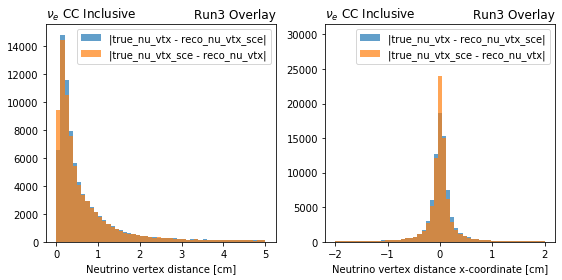

<IPython.core.display.Javascript object>

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["NUE"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")

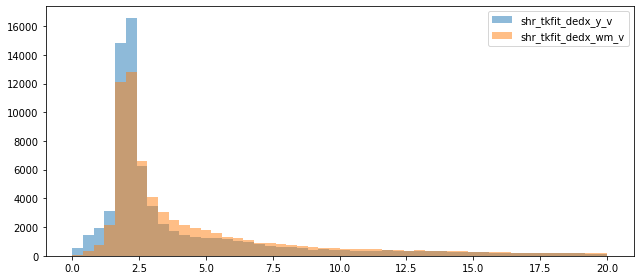

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 4))

data = sample_info["NUE"]["daughters"].query("e_candidate & abs(backtracked_pdg==11)")[
    ["shr_tkfit_dedx_y_v", "shr_tkfit_dedx_wm_v"]
]

for col in data.columns:
    ax.hist(data[col], bins=50, range=(0, 20), label=col, alpha=0.5)
ax.legend()

fig.tight_layout()
fig.savefig(output_dir + "e_preselection_dedx.pdf")